#### MCS stats using the 20-year tracking stats dataset

In [45]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

from scipy.stats import pearsonr

import warnings

In [63]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['mathtext.default'] = 'regular'

In [3]:
mcsstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
featstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean')

In [4]:
%%time
year_list = np.arange(2001,2021)

track_sum = 0

data_mcsstats_list = []
data_featstats_list = []
for n,year in enumerate(year_list):
    
    data_mcsstats = xr.open_dataset(mcsstats_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    data_featstats = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    
    # reset track number 
    if n == 0:
        data_mcsstats['tracks'] = np.arange(len(data_mcsstats.tracks))
        data_featstats['tracks'] = np.arange(len(data_mcsstats.tracks))
    else: 
        data_mcsstats['tracks'] = np.arange(track_sum, track_sum+len(data_mcsstats.tracks))
        data_featstats['tracks'] = np.arange(track_sum, track_sum+len(data_mcsstats.tracks))

    track_sum += len(data_mcsstats.tracks) 
    data_mcsstats_list.append(data_mcsstats)
    data_featstats_list.append(data_featstats)

# merge into a single file
data_mcsstats_20yr = xr.concat(data_mcsstats_list, dim='tracks')
data_featstats_20yr = xr.concat(data_featstats_list, dim='tracks')

CPU times: user 2min 37s, sys: 5min 18s, total: 7min 56s
Wall time: 7min 58s


In [5]:
# MCS, ocean
ls_flag = data_mcsstats_20yr.landsea_flag
idx_mcs_oce = np.where(ls_flag[:,0] == 0)[0]
data_mcsstats_oce = data_mcsstats_20yr.isel(tracks=idx_mcs_oce)
data_feat_oce = data_featstats_20yr.isel(tracks=idx_mcs_oce)

########################################
# in MCS stats file
mcs_duration = data_mcsstats_oce.mcs_duration
pf_npf = data_mcsstats_oce.pf_npf
tot_rain = data_mcsstats_oce.total_rain
ccs_area = data_mcsstats_oce.ccs_area
core_area = data_mcsstats_oce.core_area
cold_area = data_mcsstats_oce.cold_area
pf_maxrainrate = data_mcsstats_oce.pf_maxrainrate.max('nmaxpf')

idt_mcs_init = data_mcsstats_oce.idt_mcs_init
idt_mcs_grow = data_mcsstats_oce.idt_mcs_grow
idt_mcs_mature = data_mcsstats_oce.idt_mcs_mature

In [6]:
# number of precipitating feature at different MCS phases
ccs_area_mature = ccs_area.sel(times=idt_mcs_mature)
core_area_mature = core_area.sel(times=idt_mcs_mature)
core_frac_mature = core_area_mature/ccs_area_mature
cold_area_mature = cold_area.sel(times=idt_mcs_mature)

tot_rain_mature = data_mcsstats_oce.total_rain.sel(times=idt_mcs_mature)/(ccs_area_mature/100) # (mm/hr)

pf_maxrainrate_mature = pf_maxrainrate.sel(times=idt_mcs_mature)
pf_npf_init = pf_npf.sel(times=idt_mcs_init)
pf_npf_grow = pf_npf.sel(times=idt_mcs_grow)
pf_npf_mature = pf_npf.sel(times=idt_mcs_mature)

pf_npf_init = pf_npf.sel(times=idt_mcs_init)
pf_npf_grow = pf_npf.sel(times=idt_mcs_grow)
pf_npf_mature = pf_npf.sel(times=idt_mcs_mature)

# in buoyancy feature stats file
BL_TOT_mcs = data_feat_oce.BL_TOT_mcs.sel(mcs_phase='Mature')
BL_CAPE_mcs = data_feat_oce.BL_CAPE_mcs.sel(mcs_phase='Mature')
BL_SUBSAT_mcs = data_feat_oce.BL_SUBSAT_mcs.sel(mcs_phase='Mature')

BL_TOT_3deg = data_feat_oce.BL_TOT_3degmean.sel(mcs_phase='Mature')
BL_positive_area = data_feat_oce.BL_positive_area.sel(mcs_phase='Mature')
BL_TOT_bp = data_feat_oce.BL_TOT_bp.sel(mcs_phase='Mature')

(0.0, 10.0)

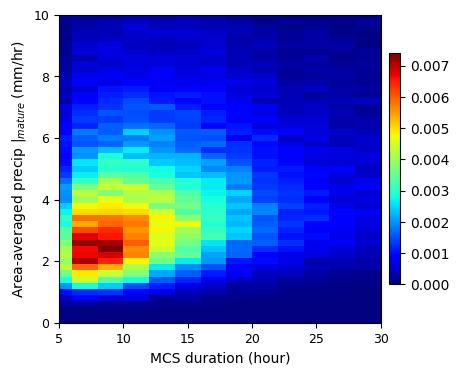

In [44]:
fig = plt.figure(figsize=(5,4))

bins_duration = np.arange(5,61,2)
bins_pmax = np.arange(0,20,0.2)

(samples, x, y) = np.histogram2d(mcs_duration, tot_rain_mature, bins=(bins_duration, bins_pmax))
plt.pcolormesh(x[:-1],y[:-1], (samples/np.sum(samples)).T, cmap='jet')
plt.colorbar(shrink=0.75, pad=0.02)
plt.xlabel('MCS duration (hour)', fontsize=10)
plt.ylabel('Area-averaged precip |$_{mature}$ (mm/hr)',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([5,30])
plt.ylim([0,10])

In [48]:
res = pearsonr(mcs_duration, pf_maxrainrate_mature)
res

PearsonRResult(statistic=0.31903569348326294, pvalue=0.0)

(5.0, 30.0)

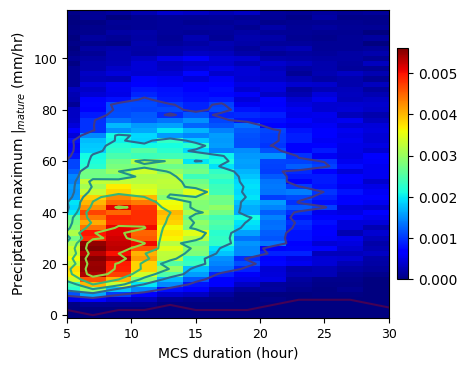

In [43]:
fig = plt.figure(figsize=(5,4))

bins_duration = np.arange(5,61,2)
bins_pmax = np.arange(0,122,2)

(samples, x, y) = np.histogram2d(mcs_duration, pf_maxrainrate_mature, bins=(bins_duration, bins_pmax))
plt.pcolormesh(x[:-1],y[:-1], (samples/np.sum(samples)).T, cmap='jet')
plt.colorbar(shrink=0.75, pad=0.02)
plt.contour(x[:-1],y[:-1], (samples/np.sum(samples)).T, levels=6)
plt.xlabel('MCS duration (hour)', fontsize=10)
plt.ylabel('Preciptation maximum |$_{mature}$ (mm/hr)',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([5,30])

Text(0.5, 1.0, 'Duration vs MCS area (km)')

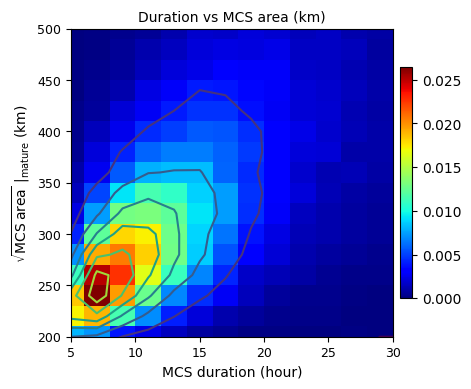

In [80]:
fig = plt.figure(figsize=(5,4))

bins_duration = np.arange(5,61,2)
bins_var = np.arange(0,1000,20)

(samples, x, y) = np.histogram2d(mcs_duration, np.sqrt(ccs_area_mature), bins=(bins_duration, bins_var))
plt.pcolormesh(x[:-1],y[:-1], (samples/np.sum(samples)).T, cmap='jet')
plt.colorbar(shrink=0.75, pad=0.02)
plt.contour(x[:-1],y[:-1], (samples/np.sum(samples)).T, levels=6)
plt.xlabel('MCS duration (hour)', fontsize=10)
plt.ylabel(r'$\sqrt{MCS\:area}$ |$_{mature}$ (km)',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([5,30])
plt.ylim([200,500])
plt.title('Duration vs MCS area (km)', fontsize=10)

(5.0, 30.0)

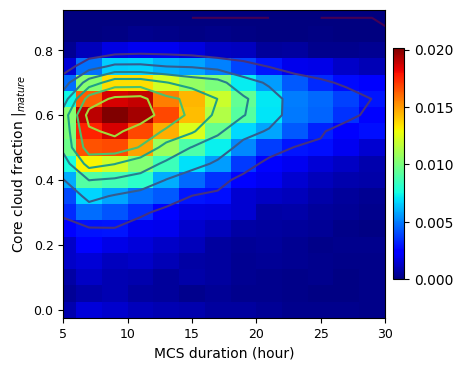

In [54]:
fig = plt.figure(figsize=(5,4))

bins_duration = np.arange(5,61,2)
bins_var = np.arange(0,1,0.05)

(samples, x, y) = np.histogram2d(mcs_duration, core_frac_mature, bins=(bins_duration, bins_var))
plt.pcolormesh(x[:-1],y[:-1], (samples/np.sum(samples)).T, cmap='jet')
plt.colorbar(shrink=0.75, pad=0.02)
plt.contour(x[:-1],y[:-1], (samples/np.sum(samples)).T, levels=6)
plt.xlabel('MCS duration (hour)', fontsize=10)
plt.ylabel('Core cloud fraction |$_{mature}$',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([5,30])
#plt.ylim([200,800])

(5.0, 30.0)

<Figure size 500x400 with 0 Axes>

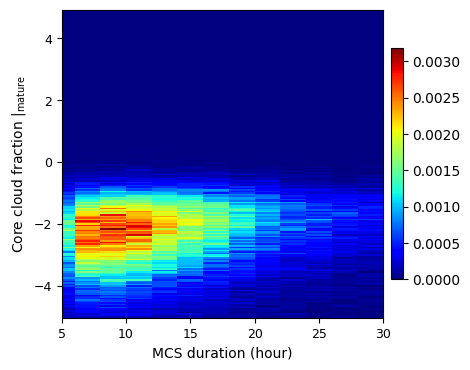

In [ ]:
fig = plt.figure(figsize=(5,4))

bins_duration = np.arange(5,61,2)
bins_var = np.arange(-5,5,0.05)

(samples, x, y) = np.histogram2d(mcs_duration, 340*3/9.8*BL_TOT_mcs, bins=(bins_duration, bins_var))
plt.pcolormesh(x[:-1],y[:-1], (samples/np.sum(samples)).T, cmap='jet')
plt.colorbar(shrink=0.75, pad=0.02)
#plt.contour(x[:-1],y[:-1], (samples/np.sum(samples)).T, levels=6)
plt.xlabel('MCS duration (hour)', fontsize=10)
plt.ylabel('Core cloud fraction |$_{mature}$',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([5,30])
#plt.ylim([200,800])

(5.0, 30.0)

<Figure size 500x400 with 0 Axes>

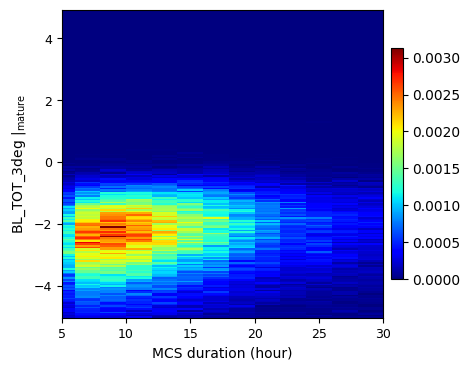

In [82]:
fig = plt.figure(figsize=(5,4))

fig = plt.figure(figsize=(5,4))

bins_duration = np.arange(5,61,2)
bins_var = np.arange(-5,5,0.05)

(samples, x, y) = np.histogram2d(mcs_duration, 340*3/9.8*BL_TOT_3deg, bins=(bins_duration, bins_var))
plt.pcolormesh(x[:-1],y[:-1], (samples/np.sum(samples)).T, cmap='jet')
plt.colorbar(shrink=0.75, pad=0.02)
#plt.contour(x[:-1],y[:-1], (samples/np.sum(samples)).T, levels=6)
plt.xlabel('MCS duration (hour)', fontsize=10)
plt.ylabel('BL_TOT_3deg |$_{mature}$',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([5,30])
#plt.ylim([200,800])

(5.0, 30.0)

<Figure size 500x400 with 0 Axes>

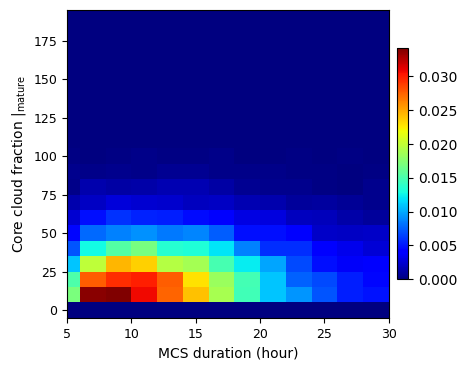

In [81]:
fig = plt.figure(figsize=(5,4))

fig = plt.figure(figsize=(5,4))

bins_duration = np.arange(5,61,2)
bins_var = np.arange(0,210,10)

(samples, x, y) = np.histogram2d(mcs_duration, np.sqrt(BL_a*100), bins=(bins_duration, bins_var))
plt.pcolormesh(x[:-1],y[:-1], (samples/np.sum(samples)).T, cmap='jet')
plt.colorbar(shrink=0.75, pad=0.02)
#plt.contour(x[:-1],y[:-1], (samples/np.sum(samples)).T, levels=6)
plt.xlabel('MCS duration (hour)', fontsize=10)
plt.ylabel('Core cloud fraction |$_{mature}$',fontsize=10)
plt.tick_params(labelsize=9)
plt.xlim([5,30])
#plt.ylim([200,800])

In [ ]:
fig = plt.figure(figsize=(5,4))
plt.hist2d(mcs_duration, (340*3/9.8/0.6)*BL_SUBSAT_mcs, bins=40, density=True, cmap='jet')
plt.xlim([0,60])
plt.ylim([0,10])
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(5,4))
idx_nan = np.isnan(BL_positive_area)
plt.hist2d(mcs_duration[~idx_nan], np.sqrt(625*BL_positive_area[~idx_nan]), bins=40, density=True, cmap='jet')
plt.xlim([0,60])
plt.colorbar()

#### differences at Init?

In [72]:
# number of precipitating feature at different MCS phases
ccs_area_init = ccs_area.sel(times=idt_mcs_init)
core_area_init = core_area.sel(times=idt_mcs_init)
core_frac_init = core_area_init/ccs_area_init
cold_area_init = cold_area.sel(times=idt_mcs_init)

tot_rain_init = data_mcsstats_oce.total_rain.sel(times=idt_mcs_init)/(ccs_area_init/100)

pf_maxrainrate_init = pf_maxrainrate.sel(times=idt_mcs_init)
pf_npf_init = pf_npf.sel(times=idt_mcs_init)
pf_npf_grow = pf_npf.sel(times=idt_mcs_grow)
pf_npf_mature = pf_npf.sel(times=idt_mcs_mature)

pf_npf_init = pf_npf.sel(times=idt_mcs_init)
pf_npf_grow = pf_npf.sel(times=idt_mcs_grow)
pf_npf_mature = pf_npf.sel(times=idt_mcs_mature)

# in buoyancy feature stats file
BL_TOT_mcs = data_feat_oce.BL_TOT_mcs.sel(mcs_phase='Init')
BL_CAPE_mcs = data_feat_oce.BL_CAPE_mcs.sel(mcs_phase='Init')
BL_SUBSAT_mcs = data_feat_oce.BL_SUBSAT_mcs.sel(mcs_phase='Init')

BL_TOT_3deg = data_feat_oce.BL_TOT_3degmean.sel(mcs_phase='Init')
BL_positive_area = data_feat_oce.BL_positive_area.sel(mcs_phase='Init')
BL_TOT_bp = data_feat_oce.BL_TOT_bp.sel(mcs_phase='Init')

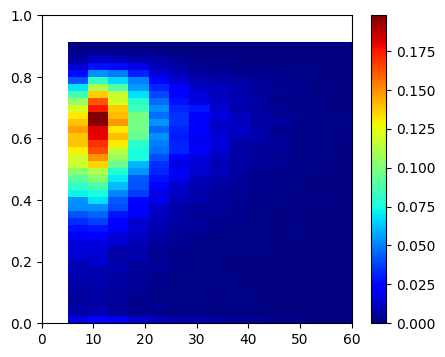

In [73]:
fig = plt.figure(figsize=(5,4))
plt.hist2d(mcs_duration, core_frac_init, bins=40, density=True, cmap='jet')
plt.xlim([0,60])
plt.ylim([0,1])
plt.colorbar()